In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial import Voronoi, voronoi_plot_2d
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
from kneed import KneeLocator

[16:38:37] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[16:38:37] Explicit valence for atom # 1 F, 2, is greater than permitted
[16:38:37] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[16:38:37] Explicit valence for atom # 2 Br, 2, is greater than permitted
[16:38:37] Explicit valence for atom # 3 F, 2, is greater than permitted
[16:38:37] Explicit valence for atom # 1 Br, 2, is greater than permitted
[16:38:37] Explicit valence for atom # 1 F, 2, is greater than permitted
[16:38:37] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[16:38:37] Explicit valence for atom # 2 Br, 2, is greater than permitted
[16:38:37] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[16:38:37] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[16:38:37] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[16:38:37] Explicit valence for atom # 4 F, 2, is greater than permitted
[16:38:37] Explicit valence for atom # 3 F

Optimal number of clusters: 3


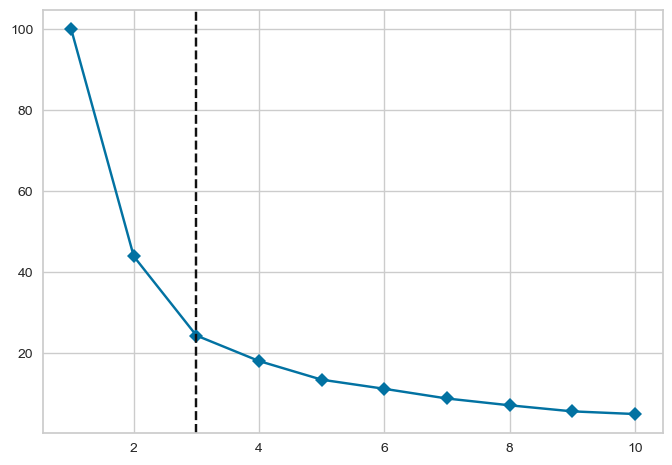

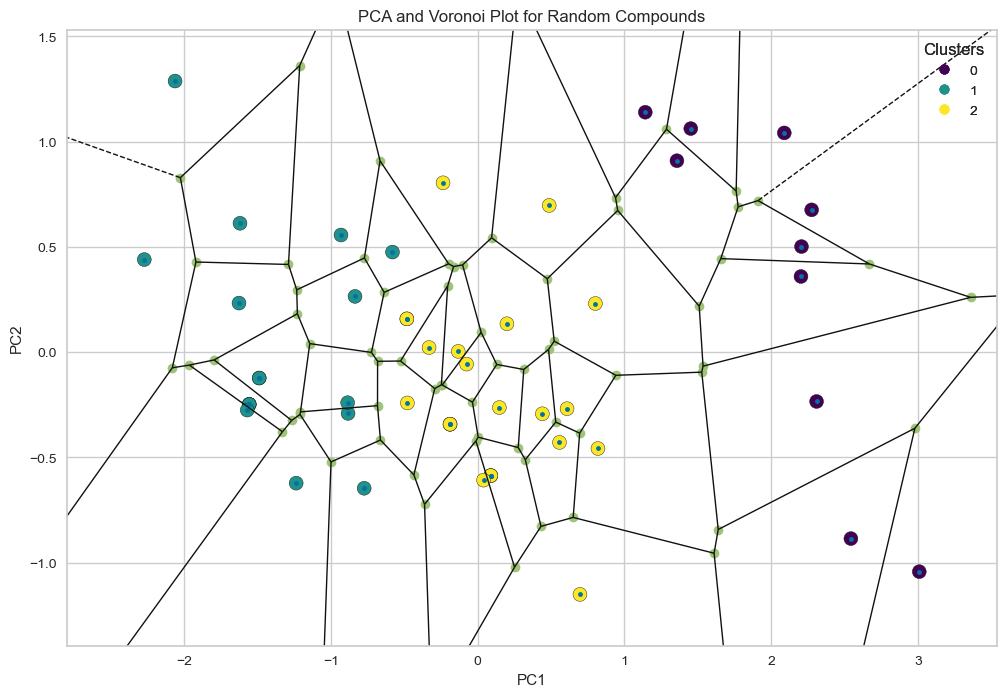

In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial import Voronoi, voronoi_plot_2d
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')

# 랜덤한 SMILES 문자열 생성
def random_smiles(length):
    atom_symbols = ['C', 'N', 'O', 'S', 'P', 'F', 'Cl', 'Br', 'I']
    mol = Chem.MolFromSmiles(''.join([random.choice(atom_symbols) for _ in range(length)]))
    while mol is None:
        mol = Chem.MolFromSmiles(''.join([random.choice(atom_symbols) for _ in range(length)]))
    
    return Chem.MolToSmiles(mol)

random.seed(42)
smiles_list = [random_smiles(random.randint(1, 6)) for _ in range(50)]

# 물성 데이터 생성
data = []
for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    data.append([mw, logp])

# 데이터 정규화
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# 적절한 클러스터링 수 찾기
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 11), timings=False)
visualizer.fit(data_scaled)
optimal_k = visualizer.elbow_value_
print(f"Optimal number of clusters: {optimal_k}")

# k-means 클러스터링
kmeans = KMeans(n_clusters=optimal_k)
labels = kmeans.fit_predict(data_scaled)

# PCA를 사용한 차원 축소
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# PCA 결과와 클러스터 레이블을 DataFrame으로 변환
df = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df['Cluster'] = labels

# Voronoi plot과 PCA plot 그리기
vor = Voronoi(data_pca)
fig, ax = plt.subplots(figsize=(12, 8))
voronoi_plot_2d(vor, ax=ax)
scatter = ax.scatter(df['PC1'], df['PC2'], c=df['Cluster'], cmap='viridis', edgecolors='k', s=100)
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA and Voronoi Plot for Random Compounds')
plt.show()

Cluster 1 area: 6.23
Cluster 2 area: 7.68
Cluster 3 area: 5.04


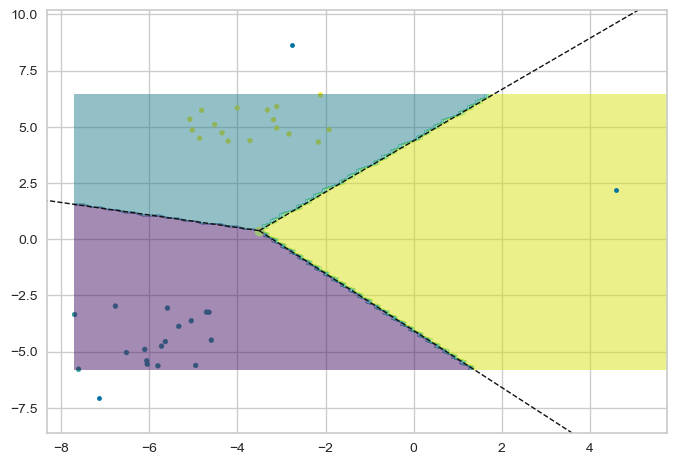

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
from kneed import KneeLocator

# 랜덤하게 화합물 50개 생성
X, _ = make_blobs(n_samples=50, centers=3, random_state=42)

# Elbow Point 계산
inertia = []
k_values = list(range(1, 50))
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

kneedle = KneeLocator(k_values, inertia, S=1.0, curve='convex', direction='decreasing')
elbow_point = kneedle.knee

# 적절한 클러스터 개수로 k-means 클러스터링
kmeans = KMeans(n_clusters=elbow_point)
clusters = kmeans.fit_predict(X)

# PCA 수행
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X)

# Voronoi diagram 그리기
vor = Voronoi(kmeans.cluster_centers_)
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax)

# PCA 결과를 클러스터링 결과와 함께 그리기
ax.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis', marker='.')

# 등고선 그래프 그리기
x = np.linspace(pca_data[:, 0].min(), pca_data[:, 0].max(), 100)
y = np.linspace(pca_data[:, 1].min(), pca_data[:, 1].max(), 100)
X_grid, Y_grid = np.meshgrid(x, y)

Z_grid = kmeans.predict(np.array([X_grid.ravel(), Y_grid.ravel()]).T)
Z_grid = Z_grid.reshape(X_grid.shape)
ax.contourf(X_grid, Y_grid, Z_grid, alpha=0.5, cmap='viridis')

# 각 클러스터의 면적 계산 및 출력
cluster_areas = []
for i in range(elbow_point):
    cluster_points = pca_data[clusters == i]
    hull = ConvexHull(cluster_points)
    area = hull.volume
    cluster_areas.append(area)
    print(f"Cluster {i + 1} area: {area:.2f}")

plt.show()


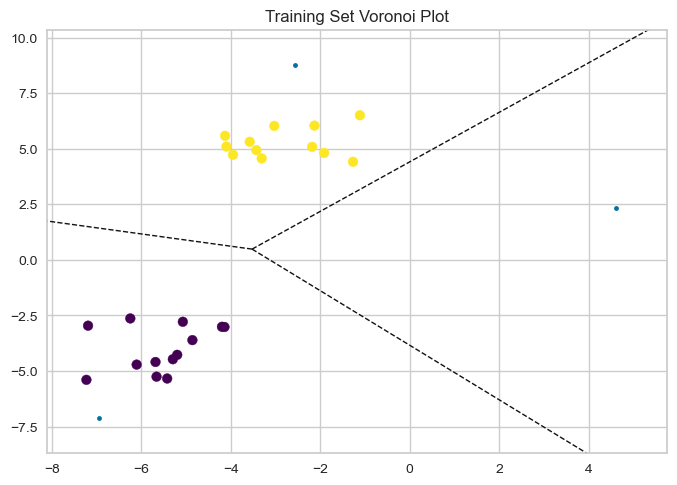

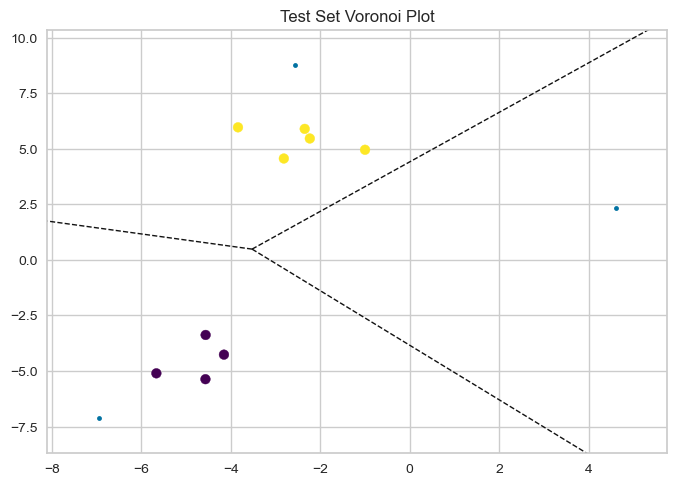

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
from sklearn.model_selection import train_test_split
from kneed import KneeLocator

# 랜덤하게 화합물 50개 생성
X, _ = make_blobs(n_samples=50, centers=3, random_state=42)

# 데이터를 학습 세트와 테스트 세트로 분할
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# Elbow method를 사용하여 최적의 클러스터 개수 찾기
sse = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    sse.append(kmeans.inertia_)

# Elbow Point 계산
kneedle = KneeLocator(K, sse, curve="convex", direction="decreasing")
n_clusters = kneedle.elbow

# 최적의 클러스터 개수로 KMeans 모델 학습
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X_train)

# 클러스터 할당
clusters_train = kmeans.predict(X_train)
clusters_test = kmeans.predict(X_test)

# PCA를 사용하여 데이터 시각화
pca = PCA(n_components=2)
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

# Voronoi plot을 그리기 위한 클러스터 중심
vor = Voronoi(kmeans.cluster_centers_)

# 학습 데이터의 Voronoi plot
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=False)
ax.scatter(pca_train[:, 0], pca_train[:, 1], c=clusters_train, cmap='viridis')
ax.set_title("Training Set Voronoi Plot")

# 테스트 데이터의 Voronoi plot
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=False)
ax.scatter(pca_test[:, 0], pca_test[:, 1], c=clusters_test, cmap='viridis')
ax.set_title("Test Set Voronoi Plot")

plt.show()


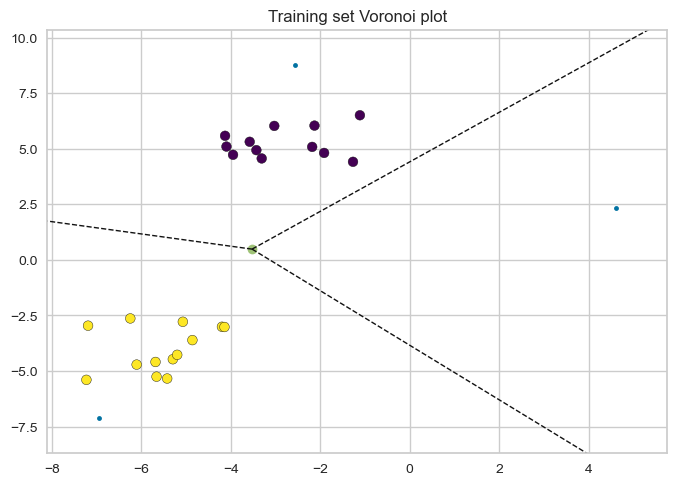

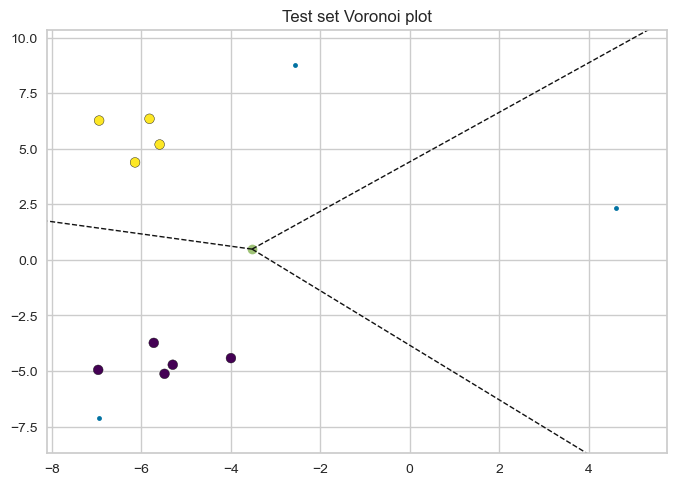

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy.spatial import Voronoi, voronoi_plot_2d
from kneed import KneeLocator
from sklearn.model_selection import train_test_split

# 랜덤하게 화합물 50개 생성
X, _ = make_blobs(n_samples=50, centers=3, random_state=42)

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# 적절한 클러스터 수를 찾기 위해 Elbow Method 사용
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train)
    inertias.append(kmeans.inertia_)

# 최적의 클러스터 수 찾기
kneedle = KneeLocator(range(1, 10), inertias, curve="convex", direction="decreasing")
optimal_k = kneedle.knee

# 최적의 클러스터 수를 사용하여 KMeans 클러스터링 수행
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(X_train)

def plot_voronoi(X, kmeans, title):
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(X)

    # Voronoi diagram 그리기
    vor = Voronoi(kmeans.cluster_centers_)
    fig, ax = plt.subplots()
    voronoi_plot_2d(vor, ax=ax)
    ax.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.predict(X), cmap='viridis', edgecolors='k')
    ax.set_title(title)

# Training set에 대한 Voronoi plot 그리기
plot_voronoi(X_train, kmeans, "Training set Voronoi plot")

# Test set에 대한 Voronoi plot 그리기
plot_voronoi(X_test, kmeans, "Test set Voronoi plot")

plt.show()


In [7]:
from scipy.spatial import ConvexHull

def cluster_areas(X, kmeans):
    clusters = kmeans.predict(X)
    unique_clusters = np.unique(clusters)
    cluster_areas = []

    for cluster_id in unique_clusters:
        cluster_points = X[clusters == cluster_id]
        if len(cluster_points) > 2:  # ConvexHull은 3개 이상의 점이 필요합니다.
            hull = ConvexHull(cluster_points)
            area = hull.volume
        else:
            area = 0
        cluster_areas.append(area)
    return cluster_areas

# Training set의 각 클러스터 면적 계산
train_cluster_areas = cluster_areas(X_train, kmeans)
print("Training set cluster areas:", train_cluster_areas)

# Test set의 각 클러스터 면적 계산
test_cluster_areas = cluster_areas(X_test, kmeans)
print("Test set cluster areas:", test_cluster_areas)

Training set cluster areas: [4.517357771930492, 2.8069488419082376, 6.366100521053106]
Test set cluster areas: [2.1300167025783106, 2.4824227765833524, 1.5021788030345546]
